# Logistic Regression — Notebook (Easy–Medium)


## Learning outcomes
- Understand logistic regression for binary classification.
- Explore and preprocess a real dataset; handle class imbalance.
- Fit logistic regression using scikit-learn (with and without regularization).
- Implement logistic regression (sigmoid, cost, gradient) from scratch using gradient descent.
- Evaluate classifiers with confusion matrix, precision/recall, F1, ROC AUC, and calibration.
- Visualize decision boundaries for 2D feature subsets and interpret coefficients.

## Notebook structure
1. Setup & dataset
2. EDA & preprocessing
3. Baseline logistic regression (single feature)
4. Full-feature logistic regression with regularization
5. Closed-form? (no closed-form) — contrast with linear regression
6. Gradient descent implementation of logistic regression
7. Decision boundary visualization (2 features)
8. Model evaluation: confusion matrix, ROC, PR curve, calibration
9. Handling class imbalance and hyperparameter tuning
10. Exercises & further reading

**Dataset used:** `breast_cancer` (from `sklearn.datasets`) — a clean, widely-used binary classification dataset.

----

All code cells are runnable. If you want the notebook adjusted (more/less detail, different dataset, multiclass extension, or a paired solutions notebook), tell me and I will create it.

In [1]:
# Setup: imports and configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, auc, accuracy_score,
                             precision_score, recall_score, f1_score, brier_score_loss)

# display settings
pd.options.display.float_format = '{:0.4f}'.format
np.set_printoptions(precision=4, suppress=True)

print('Ready — libraries imported')

Ready — libraries imported


## 1) Load dataset and construct DataFrame
We'll use the `breast_cancer` dataset from `sklearn`. Convert to a `pandas.DataFrame` for easy exploration.

In [2]:
# Load dataset and build DataFrame
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
# target: 0 = malignant, 1 = benign (note: sklearn mapping) - we'll check

df = pd.concat([X, y], axis=1)
print('Dataset shape:', df.shape)
print('\nTarget value counts:')
print(df['target'].value_counts())

df.head()

Dataset shape: (569, 31)

Target value counts:
target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.9900,10.3800,122.8000,1001.0000,0.1184,0.2776,0.3001,0.1471,0.2419,0.0787,...,17.3300,184.6000,2019.0000,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
1,20.5700,17.7700,132.9000,1326.0000,0.0847,0.0786,0.0869,0.0702,0.1812,0.0567,...,23.4100,158.8000,1956.0000,0.1238,0.1866,0.2416,0.1860,0.2750,0.0890,0
2,19.6900,21.2500,130.0000,1203.0000,0.1096,0.1599,0.1974,0.1279,0.2069,0.0600,...,25.5300,152.5000,1709.0000,0.1444,0.4245,0.4504,0.2430,0.3613,0.0876,0
3,11.4200,20.3800,77.5800,386.1000,0.1425,0.2839,0.2414,0.1052,0.2597,0.0974,...,26.5000,98.8700,567.7000,0.2098,0.8663,0.6869,0.2575,0.6638,0.1730,0
4,20.2900,14.3400,135.1000,1297.0000,0.1003,0.1328,0.1980,0.1043,0.1809,0.0588,...,16.6700,152.2000,1575.0000,0.1374,0.2050,0.4000,0.1625,0.2364,0.0768,0


### Quick summary statistics
Look at distribution, mean, std, min/max for each feature and the target.

In [3]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,...,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000
mean,14.1273,19.2896,91.9690,654.8891,0.0964,0.1043,0.0888,0.0489,0.1812,0.0628,...,25.6772,107.2612,880.5831,0.1324,0.2543,0.2722,0.1146,0.2901,0.0839,0.6274
std,3.5240,4.3010,24.2990,351.9141,0.0141,0.0528,0.0797,0.0388,0.0274,0.0071,...,6.1463,33.6025,569.3570,0.0228,0.1573,0.2086,0.0657,0.0619,0.0181,0.4839
min,6.9810,9.7100,43.7900,143.5000,0.0526,0.0194,0.0000,0.0000,0.1060,0.0500,...,12.0200,50.4100,185.2000,0.0712,0.0273,0.0000,0.0000,0.1565,0.0550,0.0000
25%,11.7000,16.1700,75.1700,420.3000,0.0864,0.0649,0.0296,0.0203,0.1619,0.0577,...,21.0800,84.1100,515.3000,0.1166,0.1472,0.1145,0.0649,0.2504,0.0715,0.0000
50%,13.3700,18.8400,86.2400,551.1000,0.0959,0.0926,0.0615,0.0335,0.1792,0.0615,...,25.4100,97.6600,686.5000,0.1313,0.2119,0.2267,0.0999,0.2822,0.0800,1.0000
75%,15.7800,21.8000,104.1000,782.7000,0.1053,0.1304,0.1307,0.0740,0.1957,0.0661,...,29.7200,125.4000,1084.0000,0.1460,0.3391,0.3829,0.1614,0.3179,0.0921,1.0000
max,28.1100,39.2800,188.5000,2501.0000,0.1634,0.3454,0.4268,0.2012,0.3040,0.0974,...,49.5400,251.2000,4254.0000,0.2226,1.0580,1.2520,0.2910,0.6638,0.2075,1.0000


### Correlation with target & top features
Compute correlations with the target and inspect top features that separate classes.

Top correlations with target:
target                 1.0000
worst concave points   0.7936
worst perimeter        0.7829
mean concave points    0.7766
worst radius           0.7765
mean perimeter         0.7426
worst area             0.7338
mean radius            0.7300
mean area              0.7090
mean concavity         0.6964
worst concavity        0.6596
mean compactness       0.5965
Name: target, dtype: float64

Top features: ['worst concave points', 'worst perimeter', 'mean concave points']


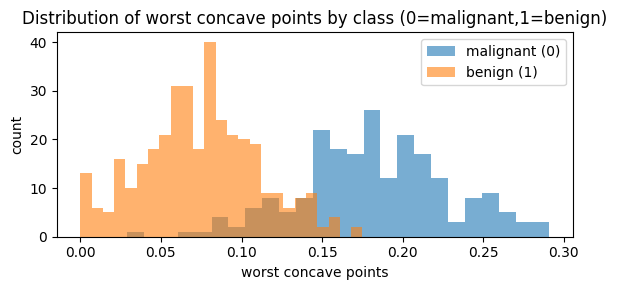

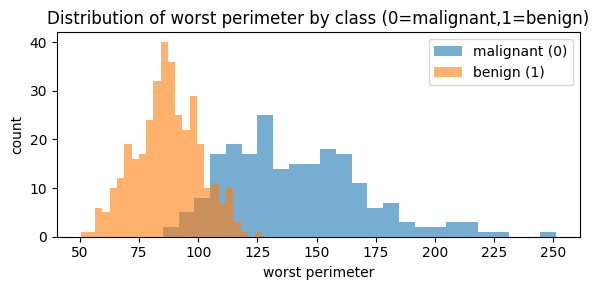

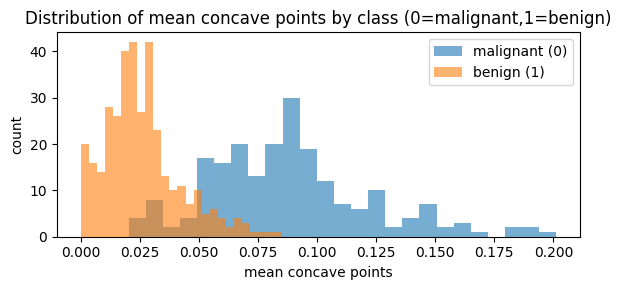

In [4]:
# Correlation with target (Pearson)
corr = df.corr()
corr_target = corr['target'].abs().sort_values(ascending=False)
print('Top correlations with target:')
print(corr_target.head(12))

# Visualize distributions for top 3 features
top_feats = list(corr_target.index[1:4])  # skip 'target' itself
print('\nTop features:', top_feats)
for f in top_feats:
    plt.figure(figsize=(6,3))
    plt.hist(df.loc[df['target']==0, f], bins=25, alpha=0.6)
    plt.hist(df.loc[df['target']==1, f], bins=25, alpha=0.6)
    plt.title(f'Distribution of {f} by class (0=malignant,1=benign)')
    plt.xlabel(f)
    plt.ylabel('count')
    plt.legend(['malignant (0)', 'benign (1)'])
    plt.tight_layout()
    plt.show()

## 2) Preprocessing: train/test split and scaling
Logistic Regression benefits from feature scaling (especially when using regularization). We'll split the data and scale features.

In [5]:
# Train-test split
X = df.drop(columns=['target']).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train shape:', X_train_scaled.shape, 'Test shape:', X_test_scaled.shape)

Train shape: (455, 30) Test shape: (114, 30)


## 3) Baseline: Logistic Regression (single feature)
Start simple: predict class using a single strong feature (e.g., `mean radius`). We'll fit, evaluate, and plot the decision boundary (probability curve).

Coefficient: -3.689547313297966 Intercept: 0.6285999995564698

Classification report (single feature):
              precision    recall  f1-score   support

           0     0.8095    0.8095    0.8095        42
           1     0.8889    0.8889    0.8889        72

    accuracy                         0.8596       114
   macro avg     0.8492    0.8492    0.8492       114
weighted avg     0.8596    0.8596    0.8596       114



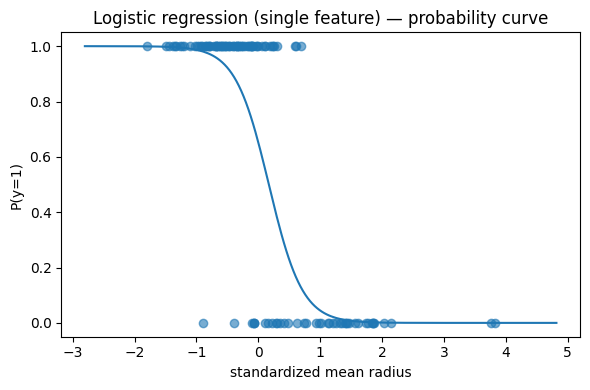

In [7]:
# Single feature: 'mean radius' (first feature name)
feat_idx = 0
X_train_1 = X_train_scaled[:, feat_idx].reshape(-1,1)
X_test_1 = X_test_scaled[:, feat_idx].reshape(-1,1)

clf = LogisticRegression(penalty=None, solver='lbfgs', max_iter=500).fit(X_train_1, y_train)
print('Coefficient:', clf.coef_[0][0], 'Intercept:', clf.intercept_[0])

# Predictions and metrics
y_pred = clf.predict(X_test_1)
y_prob = clf.predict_proba(X_test_1)[:,1]

print('\nClassification report (single feature):')
print(classification_report(y_test, y_pred, digits=4))

# Probability vs feature plot
xs = np.linspace(X_test_1.min()-1, X_test_1.max()+1, 200).reshape(-1,1)
probs = clf.predict_proba(xs)[:,1]
plt.figure(figsize=(6,4))
plt.scatter(X_test_1, y_test, alpha=0.6)
plt.plot(xs, probs)
plt.xlabel('standardized mean radius')
plt.ylabel('P(y=1)')
plt.title('Logistic regression (single feature) — probability curve')
plt.tight_layout()
plt.show()

## 4) Full-feature Logistic Regression (regularization)
Fit logistic regression using all features. We'll show unregularized and regularized models (L2, L1) and compare metrics.

In [9]:
# Standard (L2) logistic regression
clf_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)
clf_l1 = LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=10000).fit(X_train_scaled, y_train)
clf_none = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)

models = {'L2 (C=1.0)': clf_l2, 'L1 (C=1.0)': clf_l1, 'No penalty': clf_none}
rows = []
for name, m in models.items():
    y_pred = m.predict(X_test_scaled)
    rows.append({'model': name,
                 'accuracy': accuracy_score(y_test, y_pred),
                 'precision': precision_score(y_test, y_pred),
                 'recall': recall_score(y_test, y_pred),
                 'f1': f1_score(y_test, y_pred),
                 'roc_auc': roc_auc_score(y_test, m.predict_proba(X_test_scaled)[:,1])})

pd.DataFrame(rows).set_index('model')

,accuracy,precision,recall,f1,roc_auc
model,,,,,
L2 (C=1.0),0.9825,0.9861,0.9861,0.9861,0.9954
L1 (C=1.0),0.9912,0.9863,1.0000,0.9931,0.9967
No penalty,0.9211,0.9701,0.9028,0.9353,0.9719


### Coefficients interpretation
Look at coefficients (after scaling) to judge feature importance. L1 may set some coefficients to zero.

In [10]:
coef_df = pd.DataFrame({
    'feature': data.feature_names,
    'No_penalty': clf_none.coef_[0],
    'L2_coef': clf_l2.coef_[0],
    'L1_coef': clf_l1.coef_[0]
})
coef_df_sorted = coef_df.reindex(coef_df['L2_coef'].abs().sort_values(ascending=False).index)
coef_df_sorted.head(12)

,feature,No_penalty,L2_coef,L1_coef
21,worst texture,-25.7933,-1.2551,-1.2411
10,radius error,-168.3716,-1.0830,-1.8099
27,worst concave points,-22.1694,-0.9537,-1.6666
23,worst area,-165.8655,-0.9478,-2.1281
20,worst radius,-59.4358,-0.9476,-2.2068
28,worst symmetry,-61.5131,-0.9392,-0.6652
13,area error,-204.4353,-0.9291,-0.6561
26,worst concavity,-262.5692,-0.8232,-0.7242
22,worst perimeter,8.5084,-0.7632,-0.0426
24,worst smoothness,-31.0208,-0.7466,-0.5932


## 5) Closed-form? (No closed-form solution)
Unlike linear regression, logistic regression does not have a simple closed-form solution for the parameters. We rely on iterative optimization (e.g., Newton's method, LBFGS, gradient descent). We'll implement gradient descent next to gain intuition.

## 6) Logistic Regression from scratch (Gradient Descent)
We'll implement the sigmoid, loss (log-loss), gradient, and batch gradient descent. This is educational — production code should use optimized solvers.

iter 0, loss 0.693147
iter 600, loss 0.050518
iter 1200, loss 0.047665
iter 1800, loss 0.046425
iter 2400, loss 0.045691

Learned intercept: -0.024130222311633268
Learned first 5 coefs: [-0.4662 -0.4513 -0.391  -0.5972 -0.2204]


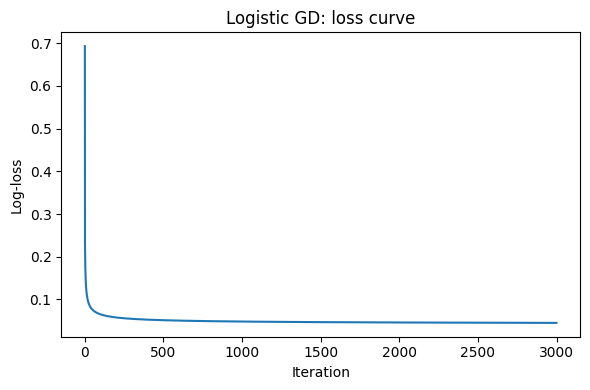


Sklearn intercept: -0.3604468554866662
Sklearn first 5 coefs: [-0.1758 -0.4212 -0.1238 -0.464  -0.326 ]

Our GD model metrics:
Accuracy: 0.9824561403508771
ROC AUC: 0.9953703703703703


In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss_and_grad(theta, X, y, reg=0.0):
    # X: (m,n) with intercept column included
    m = X.shape[0]
    z = X.dot(theta)
    preds = sigmoid(z)
    # avoid log(0)
    eps = 1e-9
    loss = - (1/m) * np.sum(y * np.log(preds + eps) + (1-y) * np.log(1 - preds + eps))
    # L2 regularization on theta[1:]
    loss += (reg/(2*m)) * np.sum(theta[1:]**2)
    grad = (1/m) * X.T.dot(preds - y)
    grad[1:] += (reg/m) * theta[1:]
    return loss, grad

def logistic_gradient_descent(X, y, lr=0.1, n_iter=1000, reg=0.0, verbose=False):
    m, n = X.shape
    theta = np.zeros(n)
    history = []
    for i in range(n_iter):
        loss, grad = logistic_loss_and_grad(theta, X, y, reg)
        theta -= lr * grad
        history.append(loss)
        if verbose and (i % max(1, (n_iter//5)) == 0):
            print(f'iter {i}, loss {loss:0.6f}')
    return theta, history

# Prepare X with intercept and scaled features
X_all = np.hstack([np.ones((X_train_scaled.shape[0],1)), X_train_scaled])
X_all_test = np.hstack([np.ones((X_test_scaled.shape[0],1)), X_test_scaled])

theta, hist = logistic_gradient_descent(X_all, y_train, lr=0.5, n_iter=3000, reg=0.1, verbose=True)

print('\nLearned intercept:', theta[0])
print('Learned first 5 coefs:', theta[1:6])

plt.figure(figsize=(6,4))
plt.plot(hist)
plt.xlabel('Iteration')
plt.ylabel('Log-loss')
plt.title('Logistic GD: loss curve')
plt.tight_layout()
plt.show()

# Compare to sklearn (L2)
from sklearn.linear_model import LogisticRegression as SkLogReg
sk = SkLogReg(penalty='l2', C=1/0.1, solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)
print('\nSklearn intercept:', sk.intercept_[0])
print('Sklearn first 5 coefs:', sk.coef_[0][:5])

# Predictions using our theta on test set
y_prob_gd = sigmoid(X_all_test.dot(theta))
y_pred_gd = (y_prob_gd >= 0.5).astype(int)
print('\nOur GD model metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred_gd))
print('ROC AUC:', roc_auc_score(y_test, y_prob_gd))

## 7) Decision boundary visualization (2 features)
Pick two informative features and visualize the decision boundary in 2D to build intuition.

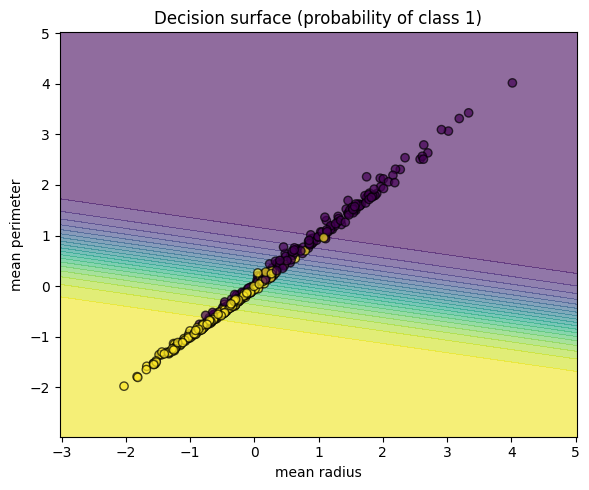

In [12]:
# Select two features (top two correlated with target)
feat_idxs = [0, 2]  # mean radius, mean perimeter (example)
X2_train = X_train_scaled[:, feat_idxs]
X2_test = X_test_scaled[:, feat_idxs]

clf_2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000).fit(X2_train, y_train)

# Meshgrid
x_min, x_max = X2_train[:,0].min()-1, X2_train[:,0].max()+1
y_min, y_max = X2_train[:,1].min()-1, X2_train[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = clf_2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, levels=20, alpha=0.6)
plt.scatter(X2_train[:,0], X2_train[:,1], c=y_train, edgecolors='k', alpha=0.7)
plt.xlabel(data.feature_names[feat_idxs[0]])
plt.ylabel(data.feature_names[feat_idxs[1]])
plt.title('Decision surface (probability of class 1)')
plt.tight_layout()
plt.show()

## 8) Model evaluation: confusion matrix, ROC, Precision-Recall, calibration
We'll compute common metrics and plot ROC and Precision-Recall curves. We'll also show calibration (reliability) plot and Brier score.

==== L2 ====
Confusion matrix:
[[41  1]
 [ 1 71]]

Classification report:
              precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114

==== L1 ====
Confusion matrix:
[[41  1]
 [ 0 72]]

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9762    0.9880        42
           1     0.9863    1.0000    0.9931        72

    accuracy                         0.9912       114
   macro avg     0.9932    0.9881    0.9905       114
weighted avg     0.9913    0.9912    0.9912       114

==== No_penalty ====
Confusion matrix:
[[40  2]
 [ 7 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8511    0.9524    0.8989        42
       

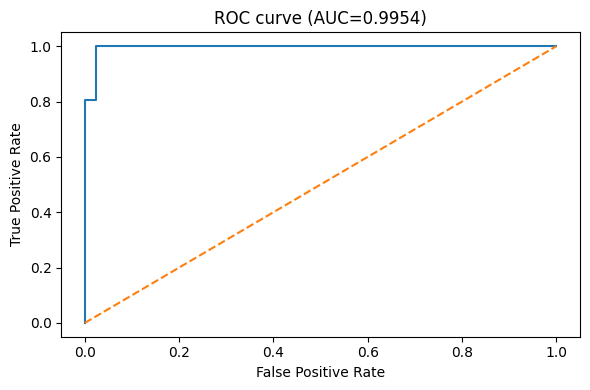

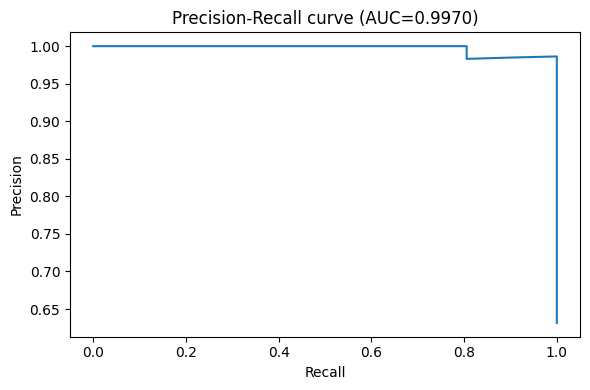

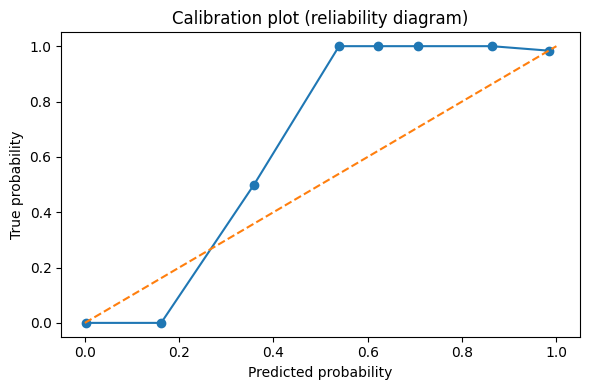

Brier score (lower better): 0.021541277444042373


In [13]:
# Confusion matrix & classification report
for name, m in [('L2', clf_l2), ('L1', clf_l1), ('No_penalty', clf_none)]:
    y_pred = m.predict(X_test_scaled)
    print(f'==== {name} ====', flush=True)
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, digits=4))

# ROC curve for L2
y_prob = clf_l2.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC={roc_auc:0.4f})')
plt.tight_layout()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC={pr_auc:0.4f})')
plt.tight_layout()
plt.show()

# Calibration: reliability diagram (simple)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot (reliability diagram)')
plt.tight_layout()
plt.show()

print('Brier score (lower better):', brier_score_loss(y_test, y_prob))

## 9) Handling class imbalance & hyperparameter tuning
Discuss `class_weight='balanced'`, threshold tuning, and use `GridSearchCV` to find best `C` (inverse regularization strength).

In [14]:
# Class weights
clf_balanced = LogisticRegression(class_weight='balanced', max_iter=10000).fit(X_train_scaled, y_train)
print('Balanced model accuracy:', accuracy_score(y_test, clf_balanced.predict(X_test_scaled)))

# GridSearch for C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000), param_grid, cv=5, scoring='roc_auc')
gs.fit(X_train_scaled, y_train)
print('Best params (by ROC AUC):', gs.best_params_, 'Best score:', gs.best_score_)

best = gs.best_estimator_
print('\nTest ROC AUC with best estimator:', roc_auc_score(y_test, best.predict_proba(X_test_scaled)[:,1]))

Balanced model accuracy: 0.956140350877193
Best params (by ROC AUC): {'C': 0.1} Best score: 0.9936016511867904

Test ROC AUC with best estimator: 0.9957010582010581


## 10) Practical tips (summary)
- Scale features before applying regularization or gradient-based solvers.
- Prefer L2 (ridge) regularization for stable solutions; use L1 for feature selection.
- Check class balance; consider `class_weight='balanced'` or resampling when needed.
- Use ROC AUC and Precision-Recall AUC; PR AUC more informative when classes are imbalanced.
- Calibrate probability estimates if you need reliable probabilities (Platt scaling or isotonic regression).

----


## 11) Exercises & further reading
**Exercises:**
1. Repeat the notebook using the `iris` dataset but convert it to a binary problem (e.g., setosa vs non-setosa). Compare metrics.
2. Implement Newton-Raphson (a.k.a. IRLS) for logistic regression and compare convergence speed to gradient descent.
3. Create learning curves (train vs validation score) to check for under/overfitting.
4. Try calibration techniques (`CalibratedClassifierCV`) and compare Brier score.

**Further reading:**
- Bishop — *Pattern Recognition and Machine Learning* (logistic regression chapters)
- Hastie, Tibshirani, Friedman — *The Elements of Statistical Learning*
- Scikit-learn documentation: LogisticRegression and metrics



In [15]:
# Save a small sample table for quick reference
sample = df.sample(10, random_state=2).reset_index(drop=True)
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user('Sample rows (breast_cancer)', sample)
except Exception:
    print('Sample rows:')
    display(sample)

print('Notebook cells ready')

Sample rows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,13.9400,13.1700,90.3100,594.2000,0.1248,0.0975,0.1010,0.0662,0.1976,0.0646,...,15.3800,94.5200,653.3000,0.1394,0.1364,0.1559,0.1015,0.2160,0.0725,1
1,14.9600,19.1000,97.0300,687.3000,0.0899,0.0982,0.0594,0.0482,0.1879,0.0585,...,26.1900,109.1000,809.8000,0.1313,0.3030,0.1804,0.1489,0.2962,0.0847,1
2,9.6680,18.1000,61.0600,286.3000,0.0831,0.0543,0.0148,0.0058,0.1680,0.0641,...,24.6200,71.1100,380.2000,0.1388,0.1255,0.0641,0.0250,0.3057,0.0788,1
3,22.2700,19.6700,152.8000,1509.0000,0.1326,0.2768,0.4264,0.1823,0.2556,0.0704,...,28.0100,206.8000,2360.0000,0.1701,0.6997,0.9608,0.2910,0.4055,0.0979,0
4,14.4200,16.5400,94.1500,641.2000,0.0975,0.1139,0.0801,0.0422,0.1912,0.0641,...,21.5100,111.4000,862.1000,0.1294,0.3371,0.3755,0.1414,0.3053,0.0876,1
5,19.5500,28.7700,133.6000,1207.0000,0.0926,0.2063,0.1784,0.1144,0.1893,0.0623,...,36.2700,178.6000,1926.0000,0.1281,0.5329,0.4251,0.1941,0.2818,0.1005,0
6,11.7500,20.1800,76.1000,419.8000,0.1089,0.1141,0.0684,0.0374,0.1993,0.0645,...,26.2100,88.9100,543.9000,0.1358,0.1892,0.1956,0.0791,0.3168,0.0799,1
7,13.2000,15.8200,84.0700,537.3000,0.0851,0.0525,0.0015,0.0033,0.1632,0.0589,...,20.4500,92.0000,636.9000,0.1128,0.1346,0.0112,0.0250,0.2651,0.0838,1
8,12.2500,17.9400,78.2700,460.3000,0.0865,0.0668,0.0389,0.0233,0.1970,0.0623,...,25.2200,86.6000,564.2000,0.1217,0.1788,0.1943,0.0821,0.3113,0.0813,1
9,14.8100,14.7000,94.6600,680.7000,0.0847,0.0502,0.0342,0.0254,0.1659,0.0535,...,17.5800,101.7000,760.2000,0.1139,0.1011,0.1101,0.0795,0.2334,0.0614,1


Notebook cells ready
